# Sandbox for Dirichlet Processes
#### More info: http://docs.pymc.io/notebooks/dp_mix.html

In [1]:
import numpy as np
import scipy as sp
import theano.tensor as tt
from statsmodels.datasets import get_rdataset
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Sample from a Dirichlet process using stick-breaking to estimate a CDF

#### Set plotting styles

In [2]:
sns.set_style('whitegrid')
blue, *_ = sns.color_palette()

#### Seed the random number generator (same as tutorial)

In [5]:
randseed = 5132290
np.random.seed(randseed)

#### Set up the DP params

In [6]:
N = 20 #number of samples (each sample is a function)
K = 100 #maximum number of segments

alpha = 5.0 #scaling parameter
P0 = sp.stats.norm #base distribution...in this notebook, entire support is assumed to be between -3 and 3

#### Break the sticks

In [7]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K)) #draw stick lengths from a beta(1, alpha)
V = np.empty_like(beta) #array w/ junk data to store weights
#break the sticks:
V[:, 0] = beta[:, 0] #draw first break from a beta distribution
V[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1) #subsequent breaks will be beta draw * product of 1-V_(all previous breaks)

#### Draw atoms

In [8]:
theta = P0.rvs(size=(N, K)) #draw atoms from base distribution

#### Estimate the CDF

In [9]:
#x axis for plot:
x_res = 200
x_plot = np.linspace(-3, 3, x_res)

In [10]:
#zero array to catch values:
sample_cdfs = np.zeros((N, x_res))
#loop through x points, assign 1 to draws from each sample that are below a given x point, 0 to others
#then multiply by sticks and sum up to give a CDF for each sample:
for i in range(x_res):
    sample_cdfs[:, i] = (V * np.less.outer(theta, x_plot[i])).sum(axis=1)

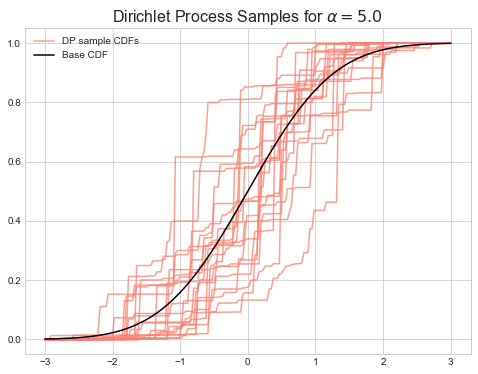

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, sample_cdfs[0], c='salmon', alpha=0.75,
        label='DP sample CDFs');
ax.plot(x_plot, sample_cdfs[1:].T, c='salmon', alpha=0.75);

ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

ax.set_title(r'Dirichlet Process Samples for $\alpha = {}$'.format(alpha), size=16);
ax.legend(loc=2);

#### The expectation value is pretty close to the base function

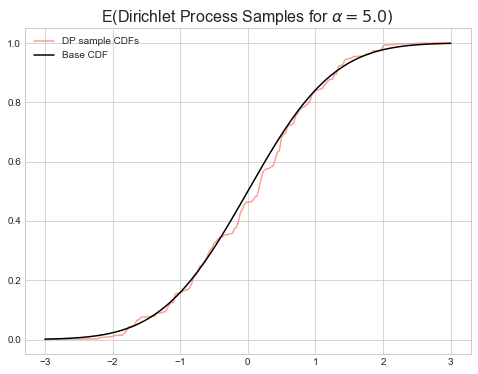

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, sample_cdfs.mean(axis=0), c='salmon', alpha=0.75,
        label='DP sample CDFs');

ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

ax.set_title(r'E(Dirichlet Process Samples for $\alpha = {})$'.format(alpha), size=16);
ax.legend(loc=2);

#### What if we skipped the stick-breaking step (for illustrative purposes)?

In [13]:
#zero array to catch values:
sample_cdfs_nostick = np.zeros((N, x_res))
#loop through x points, assign 1 to draws from each sample that are below a given x point, 0 to others
#then multiply by sticks and sum up to give a CDF for each sample:
for i in range(x_res):
    sample_cdfs_nostick[:, i] = (np.less.outer(theta, x_plot[i])).sum(axis=1)

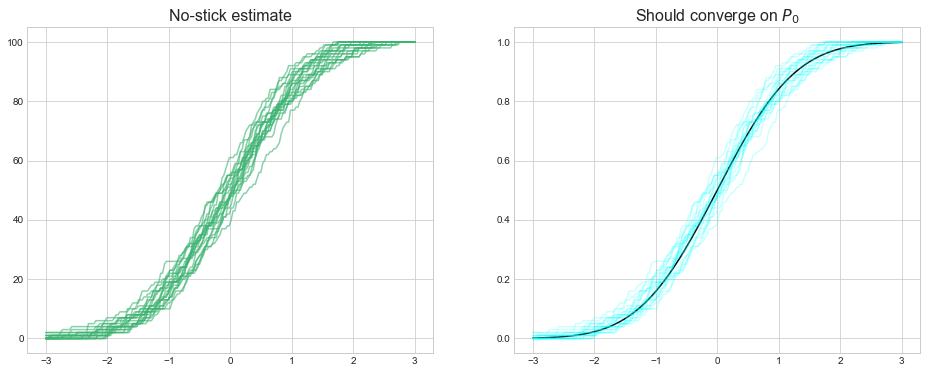

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(x_plot, sample_cdfs_nostick.T, c='mediumseagreen', alpha=0.6);
ax[0].set_title('No-stick estimate', size=16);

ax[1].plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');
ax[1].plot(x_plot, sample_cdfs_nostick.T/K, c='cyan', alpha=0.2);
ax[1].set_title('Should converge on $P_0$', size=16);

## Now, try a Polya urn sampler to estimate a DP mixture model

#### Set new params

In [358]:
N = 5 #number of samples
K = 30 #maximum K
alpha = 2 #scaling param
P0 = sp.stats.norm #base distribution
#form of mixture components:
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)
#beta for stick breaking:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))

#### Break some sticks to sample intervals
Notice the stick-breaking process is identical to the one above.

In [359]:
V = np.empty_like(beta)
V[:, 0] = beta[:, 0] #the first V in each smaple will just be a draw from the beta distribution
V[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1) #subsequent draws according to formula
theta = P0.rvs(size=(N, K)) #base distribution

In [379]:
#calculate mixture components:
dpm_pdf_components = f(x_plot[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
#weight the components to arrive at pdf:
dpm_pdfs = (V[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

#### First, let's look at the mixture without the weights

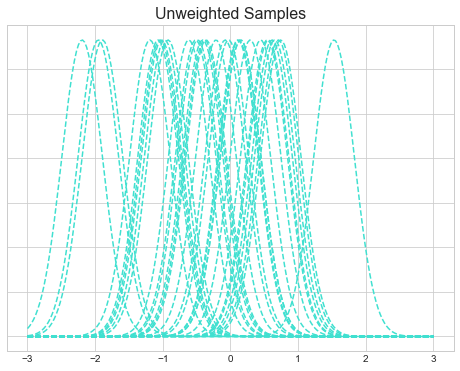

In [377]:
fig, ax = plt.subplots(figsize=(8, 6))
ix=1

ax.plot(x_plot, (dpm_pdf_components)[ix, 0],
        '--', c='turquoise');
ax.plot(x_plot, (dpm_pdf_components)[ix].T,
        '--', c='turquoise');
ax.set_title('Unweighted Samples', size=16);
ax.set_yticklabels([]);
ax.legend(loc=1);

#### Now for the weighted mixture components

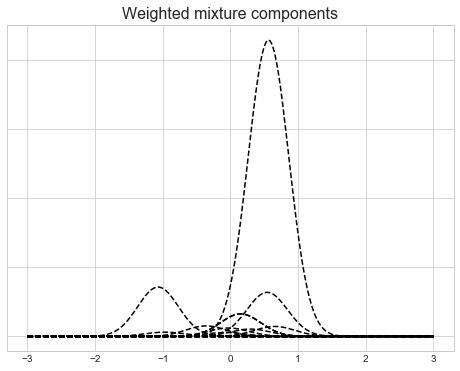

In [378]:
fig, ax = plt.subplots(figsize=(8, 6))
ix=1

ax.plot(x_plot, (V[..., np.newaxis] * dpm_pdf_components)[ix, 0],
        '--', c='k');
ax.plot(x_plot, (V[..., np.newaxis] * dpm_pdf_components)[ix].T,
        '--', c='k');

ax.set_title('Weighted mixture components', size=16);
ax.set_yticklabels([]);
ax.legend(loc=1);

#### Now, combine for the full PDF

/Users/gklobusi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2401: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


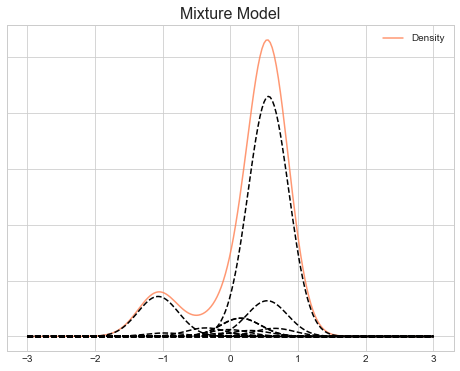

In [382]:
fig, ax = plt.subplots(figsize=(8, 6))
ix=1

ax.plot(x_plot, dpm_pdfs[ix], c='k', label='Density', color='coral', alpha=0.8);
ax.plot(x_plot, (V[..., np.newaxis] * dpm_pdf_components)[ix, 0],
        '--', c='k');
ax.plot(x_plot, (V[..., np.newaxis] * dpm_pdf_components)[ix].T,
        '--', c='k');

ax.set_title('Mixture Model', size=16);
ax.set_yticklabels([]);
ax.legend(loc=1);

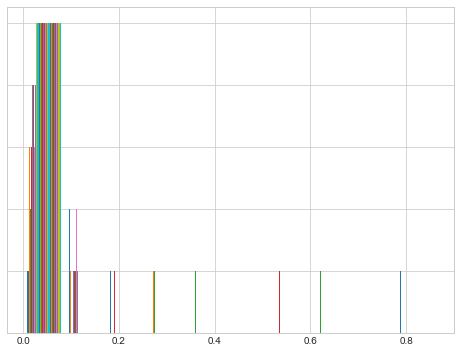

In [374]:
fig, ax = plt.subplots(figsize=(8, 6))
ix=1

ax.hist(V,
        );

ax.set_yticklabels([]);
ax.legend(loc=1);
